# PREDIÇÃO PARA CASOS MORTES CONFIRMADAS

#### IMPORTAÇÕES

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

import warnings
from sklearn.model_selection import KFold
from datetime import datetime 

from pickle import dump

# IMPORT REDES NEURAIS
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler

In [2]:
start_time = datetime.now() 

#### FUNÇÕES

In [3]:
def get_fac2(y_true, y_pred):
    min_ = 0.5
    max_ = 2
    
    eps = np.finfo(np.float).eps
    
    division = y_pred / (y_true+eps)
    
    greater_min = np.greater_equal(division, min_)
    less_max = np.less_equal(division, max_)

    res = np.equal(greater_min, less_max)
    res = res.astype(float)

    fac_2 = res.mean()

    return fac_2

In [4]:
def input_ID(df):
    lista_regiao = list(df["Country/Region"].unique())
    identificadores = np.arange(0,len(lista_regiao))
    lista_df = []
    l=0
    for i in lista_regiao:
        
        mask = df['Country/Region'] == i
        df_temp = df.loc[mask]
        df_temp.insert(0, "ID", identificadores[l] )
        lista_df.append(df_temp)
        l=l+1
    df_final = pd.concat(lista_df) 
    return df_final

def get_metrics(y_true, y_pred, filename="LSTMCNN"):
    
    metrics = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'Pearson r', 'Fac2'])
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        y_true_col = y_true.iloc[:, col]
        y_pred_col = y_pred.iloc[:, col]

        if y_true_col.name == y_pred_col.name:
            col_name = y_true_col.name
        else:
            print('Column name error.')
            return None

        mse = mean_squared_error(y_true_col, y_pred_col)
        rmse = mean_squared_error(y_true_col, y_pred_col, squared=False)
        mae = mean_absolute_error(y_true_col, y_pred_col)
        pearson_r = pearsonr(y_true_col, y_pred_col)[0]
        fac2 = get_fac2(y_true_col.values, y_pred_col.values)
        
        metrics.loc[col_name, :] = [mse, rmse, mae, pearson_r, fac2]

    metrics.loc['Average', :] = metrics.mean()
#     metrics.to_csv(local+extra+".csv",index=False)
    return metrics

def plot_metrics(dict_metrics, title='', xlabel='', ylabel=''):
    
    plt.figure(figsize=(14, 12))
    plt.suptitle(title, fontsize=14, y=0.935)
    
    keys = list(dict_metrics.keys())
    key_0 = keys[0]
    metrics_df_0 = dict_metrics[key_0]
    metrics_names = metrics_df_0.columns
    time_steps = list(range(1, metrics_df_0.shape[0]))
    
    for col, metric_name in enumerate(metrics_names):
        
        plt.subplot(3, 2, col+1)
        
        for key in dict_metrics.keys():
            
            metrics_df = dict_metrics[key]
            plt.plot(time_steps, metrics_df.iloc[0:-1, col], marker='o', label=key)
        
        plt.title('{} para cada horizonte de previsão'.format(metric_name))
        plt.legend()
        plt.xlabel('Dias a frente', fontsize=10)
        plt.ylabel(metric_name, fontsize=10)
        plt.xlim(left=time_steps[0], right=time_steps[-1])
        plt.xticks(np.linspace(time_steps[0], time_steps[-1], num=5, dtype=int))
        
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
#     plt.savefig("img/LSTM_plot_metrics "+ local + extra+".png", dpi=600)
    plt.show()

#### LEITURA DOS DADOS DO GRUPO

In [5]:
nome_arquivo_analise = "Dados_Sinteticos_Multivariado.csv"
arquivo = os.path.abspath("../../synthetic_datasets_generator/synthetic_datasets/"+nome_arquivo_analise)
dados_sinteticos = pd.read_csv(arquivo, sep="," , decimal=".")
dados_sinteticos

,Data,ID,Time,Regiao de REF,Confirmed,Deaths,C1,C2,C3,C4,C5,C6,C7,C8
0,2020-03-19,1,1,AC,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-03-20,1,2,AC,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-03-21,1,3,AC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-03-22,1,4,AC,1.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0
4,2020-03-23,1,5,AC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12001269,2020-10-19,52500,193,Yemen,0.0,0.0,-0.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0
12001270,2020-10-20,52500,194,Yemen,0.0,0.0,-0.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0
12001271,2020-10-21,52500,195,Yemen,0.0,0.0,-0.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0
12001272,2020-10-22,52500,196,Yemen,0.0,0.0,-0.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0


#### LEITURA DOS DADOS REAIS

In [6]:
#DADOS DE TREINO
nome_arquivo_analise = "train_mundial_estadual_model_20200807.csv"
arquivo = os.path.abspath("../../synthetic_datasets_generator/real_datasets/"+nome_arquivo_analise)
dados_reais_treino = pd.read_csv(arquivo,  sep="," , decimal=".")
dados_reais_treino['Date'] = dados_reais_treino['Date'].apply(lambda x: dt.datetime.strptime(x,'%m/%d/%Y'))

#### IDENTIFICANDO OS PAÍSES DESSE PACOTE
lista_paises_treino = dados_reais_treino["Country/Region"].unique()
lista_paises_treino

array(['Argentina', 'Belgium', 'Benin', 'Bhutan',
       'Bosnia and Herzegovina', 'Bulgaria', 'Cameroon', 'Canada',
       'Colombia', 'Croatia', 'Cyprus', 'Djibouti', 'Dominica', 'Ecuador',
       'France', 'Guatemala', 'Guyana', 'Honduras', 'Hungary', 'Iceland',
       'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Italy', 'Japan',
       'Kenya', 'Kyrgyzstan', 'Laos', 'Luxembourg', 'Malawi', 'Malaysia',
       'Mauritius', 'Mongolia', 'Mozambique', 'Niger', 'Nigeria',
       'Pakistan', 'Paraguay', 'Qatar', 'Sierra Leone', 'Singapore',
       'Somalia', 'South Korea', 'South Sudan', 'Sudan', 'Sweden',
       'Syria', 'Trinidad and Tobago', 'United Kingdom', 'Uzbekistan',
       'Venezuela', 'Vietnam', 'Zimbabwe', 'AC', 'PB', 'PI', 'RN', 'RO',
       'RR', 'RS', 'SE', 'China', 'United States'], dtype=object)

In [7]:
#DADOS DE VALIDAÇÃO
nome_arquivo_analise = "val_mundial_estadual_model_20200807.csv"
arquivo = os.path.abspath("../../synthetic_datasets_generator/real_datasets/"+nome_arquivo_analise)
dados_reais_val = pd.read_csv(arquivo,  sep="," , decimal=".")
dados_reais_val['Date'] = dados_reais_val['Date'].apply(lambda x: dt.datetime.strptime(x,'%m/%d/%Y'))

#### IDENTIFICANDO OS PAÍSES DESSE PACOTE
lista_paises_val = dados_reais_val["Country/Region"].unique()
lista_paises_val

array(['Andorra', 'Angola', 'Australia', 'Austria', 'Bahrain',
       'Bangladesh', 'Bolivia', 'Botswana', 'Burkina Faso', 'Cabo Verde',
       'Cambodia', 'Costa Rica', "Cote d'Ivoire", 'Cuba', 'Egypt',
       'El Salvador', 'Estonia', 'Ethiopia', 'Finland', 'Gabon', 'Gambia',
       'Georgia', 'Ghana', 'Greece', 'Guinea', 'Haiti', 'Ireland',
       'Jordan', 'Kazakhstan', 'Lesotho', 'Liberia', 'Mali', 'Mauritania',
       'Moldova', 'Namibia', 'Netherlands', 'Norway', 'Panama',
       'Papua New Guinea', 'Peru', 'Philippines', 'Romania', 'Russia',
       'Saudi Arabia', 'Slovakia', 'Slovenia', 'South Africa', 'Suriname',
       'Tajikistan', 'Thailand', 'Tunisia', 'Turkey', 'Uganda', 'Ukraine',
       'Uruguay', 'Yemen', 'AL', 'ES'], dtype=object)

In [8]:
#DADOS DE TESTE
nome_arquivo_analise = "test_mundial_estadual_model_20200807.csv"
arquivo = os.path.abspath("../../synthetic_datasets_generator/real_datasets/"+nome_arquivo_analise)
dados_reais_teste = pd.read_csv(arquivo,  sep="," , decimal=".")
dados_reais_teste['Date'] = dados_reais_teste['Date'].apply(lambda x: dt.datetime.strptime(x,'%m/%d/%Y'))

#### IDENTIFICANDO OS PAÍSES DESSE PACOTE
lista_paises_teste = dados_reais_teste["Country/Region"].unique()
lista_paises_teste

array(['Afghanistan', 'Albania', 'Algeria', 'Azerbaijan', 'Barbados',
       'Belarus', 'Belize', 'Brunei', 'Burundi',
       'Central African Republic', 'Chad', 'Chile', 'Congo (Brazzaville)',
       'Congo (Kinshasa)', 'Denmark', 'Dominican Republic', 'Eritrea',
       'Eswatini', 'Fiji', 'Germany', 'Jamaica', 'Kosovo', 'Kuwait',
       'Latvia', 'Lebanon', 'Libya', 'Lithuania', 'Madagascar', 'Mexico',
       'Morocco', 'Nepal', 'New Zealand', 'Nicaragua', 'Oman', 'Poland',
       'Portugal', 'Rwanda', 'San Marino', 'Senegal', 'Serbia',
       'Seychelles', 'Switzerland', 'Taiwan', 'Tanzania', 'Timor-Leste',
       'Togo', 'United Arab Emirates', 'Zambia', 'Brazil', 'Spain', 'BA',
       'RJ'], dtype=object)

In [9]:
#### ADICIONANDO INDENTIFICADOR NÚMERICO AO CONJUNTO DE DADOS DE TESTE
dados_reais_teste = input_ID(dados_reais_teste)
dados_reais_teste.head()

,ID,C1,C2,C3,C4,C5,C6,C7,C8,Confirmed,Country/Region,Date,Deaths,Recovered,estagio,peak,postinflex,preinflex
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Afghanistan,2020-02-24,0.0,0.0,5.0,133.0,154.0,112.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Afghanistan,2020-02-25,0.0,0.0,5.0,133.0,154.0,112.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Afghanistan,2020-02-26,0.0,0.0,5.0,133.0,154.0,112.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Afghanistan,2020-02-27,0.0,0.0,5.0,133.0,154.0,112.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Afghanistan,2020-02-28,0.0,0.0,5.0,133.0,154.0,112.0


##### DIVISÃO TREINO, VALIDAÇÃO E TESTE

In [10]:
intervalo = dados_sinteticos['Regiao de REF'].isin(lista_paises_treino) == True
dados_treino = dados_sinteticos.loc[intervalo]

intervalo = dados_sinteticos['Regiao de REF'].isin(lista_paises_val) == True
dados_val = dados_sinteticos.loc[intervalo]

intervalo = dados_sinteticos['Regiao de REF'].isin(lista_paises_teste) == True
dados_teste_sintetico = dados_sinteticos.loc[intervalo]

dados_teste = dados_reais_teste.copy()

#### QUANTIDADE DE SÉRIES SINTÉTICAS EM CADA GRUPO 

In [11]:
qtd_series = dados_treino["ID"].unique()
print(qtd_series.shape)
qtd_series = dados_val["ID"].unique()
print(qtd_series.shape)
qtd_series = dados_teste_sintetico["ID"].unique()
print(qtd_series.shape)

(19000,)
(19000,)
(14500,)


#### DEFININDO OS ATRIBUTOS QUE SERÃO UTILIZADOS

In [12]:
x_columns = ["ID","Deaths", "Confirmed", "C1","C2","C3","C4","C5","C6","C7","C8"]
y_columns = ["Deaths"]
col = x_columns + y_columns

In [13]:
dados_treino = dados_treino[col]
dados_val = dados_val[col]
dados_teste = dados_teste[col]
dados_teste_sintetico = dados_teste_sintetico[col]

print(dados_treino.shape)
print(dados_val.shape)
print(dados_teste.shape)
print(dados_teste_sintetico.shape)

(4283061, 12)
(4329191, 12)
(7780, 12)
(3389022, 12)


#### CNN - LSTM MULTIVARIADO (PREVISÃO  30 DIAS À FRENTE DE MORTES CONFIRMADAS)

In [14]:
lookback = 4
lookforward= 30

In [15]:
normalizador = MinMaxScaler(feature_range=(0, 1))

norm_dados_treino = normalizador.fit_transform(dados_treino)
norm_dados_val = normalizador.transform(dados_val)
norm_dados_teste = normalizador.transform(dados_teste)
norm_dados_teste_sintetico = normalizador.transform(dados_teste_sintetico)


normalizador_t = MinMaxScaler(feature_range=(0, 1))
previsores_normalizado = normalizador_t.fit_transform(dados_treino.iloc[:,[-1]])

In [16]:
def create_PT_multi(sequences, n_steps_in, n_steps_out):
    #Função pare desenvolvimento dos preditores
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix >= len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix+1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def preditores_targets(np_treino, vp, vf):
    identificador = np.unique(np_treino[:,0], axis=0)  
    lista_treinoX = []
    lista_treinoY = []
    for i in identificador:
        
        mask = np_treino[:,0] ==i
        dados_treino_temp = np_treino[mask]
        dados_treino_temp = dados_treino_temp[:,1:]
        
        if(vp + vf <= dados_treino_temp.shape[0]):
            treinamentoX_full, treinamentoY_full = create_PT_multi(dados_treino_temp, vp, vf) 
            lista_treinoX.append(treinamentoX_full)
            lista_treinoY.append(treinamentoY_full)
        else:
            print("A serie temporal com identificação "+ str(i) + " não foi considerada (poucos dados)")
    
    preditores = np.concatenate(lista_treinoX)
    targets = np.concatenate(lista_treinoY)
    
    return preditores, targets
    
treinamento_X_tvt, treinamento_Y_tvt = preditores_targets(norm_dados_treino, lookback, lookforward)
val_X_tvt, val_Y_tvt = preditores_targets(norm_dados_val, lookback, lookforward)
teste_X_tvt, teste_Y_tvt = preditores_targets(norm_dados_teste, lookback, lookforward)

In [17]:
print(treinamento_X_tvt.shape)
print(treinamento_Y_tvt.shape)

(3656061, 4, 10)
(3656061, 30)


In [18]:
###########################################################################################################################
#Arquitetura da RNA
activation = 'relu'
opt = optimizers.RMSprop(lr=1e-4)

val = [val_X_tvt, val_Y_tvt]

tf.random.set_seed(0)

modelo = Sequential()
modelo.add(Conv1D(filters=128, kernel_size=7, padding='same', activation= activation, input_shape = (treinamento_X_tvt.shape[1],treinamento_X_tvt.shape[2] )))
modelo.add(MaxPooling1D(pool_size=2, padding='same'))

modelo.add(LSTM(units = 40, return_sequences = True, activation=activation))
modelo.add(LSTM(units = 35, return_sequences = True, activation=activation))
modelo.add(LSTM(units = 30, activation = activation))
modelo.add(Dense(units = lookforward, activation = activation))

modelo.compile(optimizer=opt, loss='mse')

#Execução
history = modelo.fit(treinamento_X_tvt, treinamento_Y_tvt, validation_data = val, shuffle=False ,batch_size = 1500, epochs = 150, verbose=2)
###########################################################################################################################

Train on 3656061 samples, validate on 3702191 samples
Epoch 1/150
3656061/3656061 - 31s - loss: 5.8275e-04 - val_loss: 3.4971e-04
Epoch 2/150
3656061/3656061 - 24s - loss: 4.4780e-04 - val_loss: 2.9364e-04
Epoch 3/150
3656061/3656061 - 24s - loss: 4.3535e-04 - val_loss: 2.9021e-04
Epoch 4/150
3656061/3656061 - 24s - loss: 4.3444e-04 - val_loss: 2.8941e-04
Epoch 5/150
3656061/3656061 - 24s - loss: 4.3330e-04 - val_loss: 2.8777e-04
Epoch 6/150
3656061/3656061 - 23s - loss: 4.2640e-04 - val_loss: 2.8889e-04
Epoch 7/150
3656061/3656061 - 23s - loss: 4.2291e-04 - val_loss: 2.9043e-04
Epoch 8/150
3656061/3656061 - 23s - loss: 4.2058e-04 - val_loss: 2.9175e-04
Epoch 9/150
3656061/3656061 - 23s - loss: 4.1755e-04 - val_loss: 2.9484e-04
Epoch 10/150
3656061/3656061 - 23s - loss: 4.1420e-04 - val_loss: 2.9648e-04
Epoch 11/150
3656061/3656061 - 23s - loss: 4.1066e-04 - val_loss: 3.0394e-04
Epoch 12/150
3656061/3656061 - 23s - loss: 4.0786e-04 - val_loss: 3.0873e-04
Epoch 13/150
3656061/3656061 - 

In [19]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 128)            9088      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 128)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 2, 40)             27040     
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 35)             10640     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7920      
_________________________________________________________________
dense (Dense)                (None, 30)                930       
Total params: 55,618
Trainable params: 55,618
Non-trainable params: 0
____________________________________________________

#### SALVANDO O MODELO (ETAPA - TREINAMENTO, VALIDAÇÃO TESTE)

In [20]:
#modelo.save('./Modelo/Modelo_CNN_LSTM_TVT.h5')

#### VERIFICAÇÃO DO LOSS

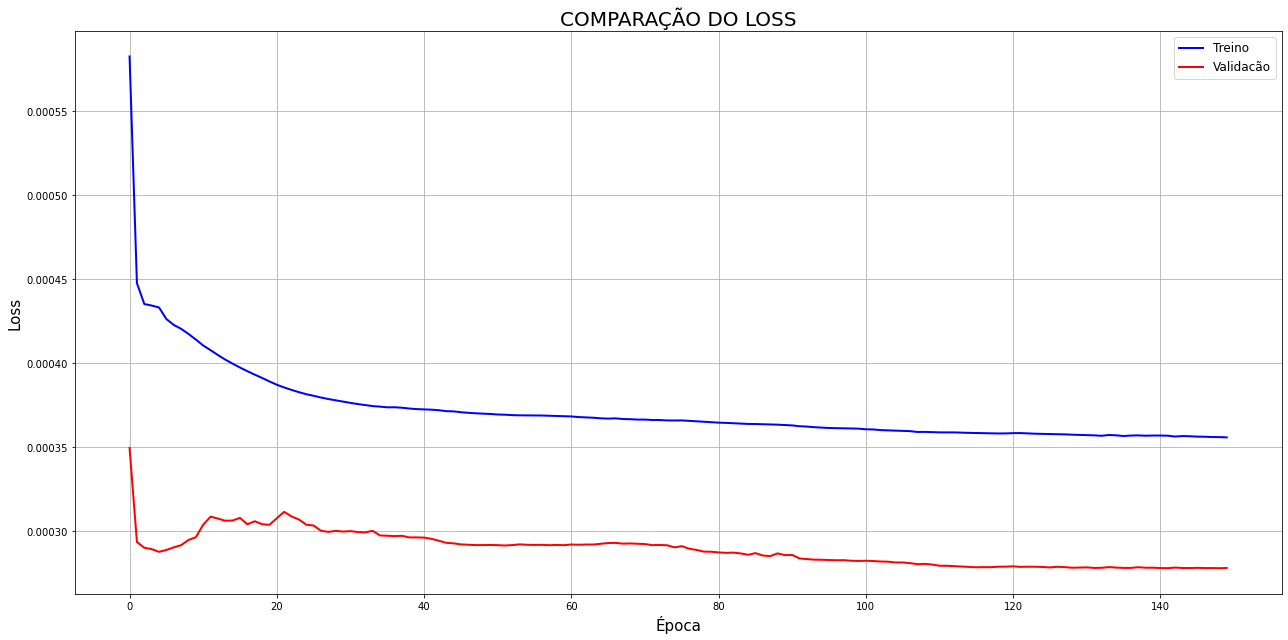

In [21]:
plt.figure(figsize=(18,9))

plt.plot(history.history['loss'], label = "Treino", linewidth =2, color ='blue')        
plt.plot(history.history['val_loss'],'-', label = "Validacão", linewidth =2, color='red')

plt.title('COMPARAÇÃO DO LOSS', fontsize =20)
plt.xlabel('Época', fontsize =15)
plt.ylabel('Loss',fontsize =15)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("Imagens/CNN_LSTM_Grafico_de_loss.png", dpi=600)
plt.show()

In [22]:
warnings.filterwarnings('ignore')
predicao = modelo.predict(treinamento_X_tvt) 
predicao = normalizador_t.inverse_transform(predicao)
observado = normalizador_t.inverse_transform(treinamento_Y_tvt)

predicao = pd.DataFrame(predicao)
observado = pd.DataFrame(observado)

train_metrics = get_metrics(observado, predicao)

In [23]:
warnings.filterwarnings('ignore')
predicao =  modelo.predict(val_X_tvt) 
predicao = normalizador_t.inverse_transform(predicao)
observado = normalizador_t.inverse_transform(val_Y_tvt)

predicao = pd.DataFrame(predicao)
observado = pd.DataFrame(observado)

val_metrics = get_metrics(observado, predicao)

In [24]:
warnings.filterwarnings('ignore')
predicao =  modelo.predict(teste_X_tvt) 
predicao = normalizador_t.inverse_transform(predicao)
observado = normalizador_t.inverse_transform(teste_Y_tvt)

predicao = pd.DataFrame(predicao)
observado = pd.DataFrame(observado)

test_metrics = get_metrics(observado, predicao)

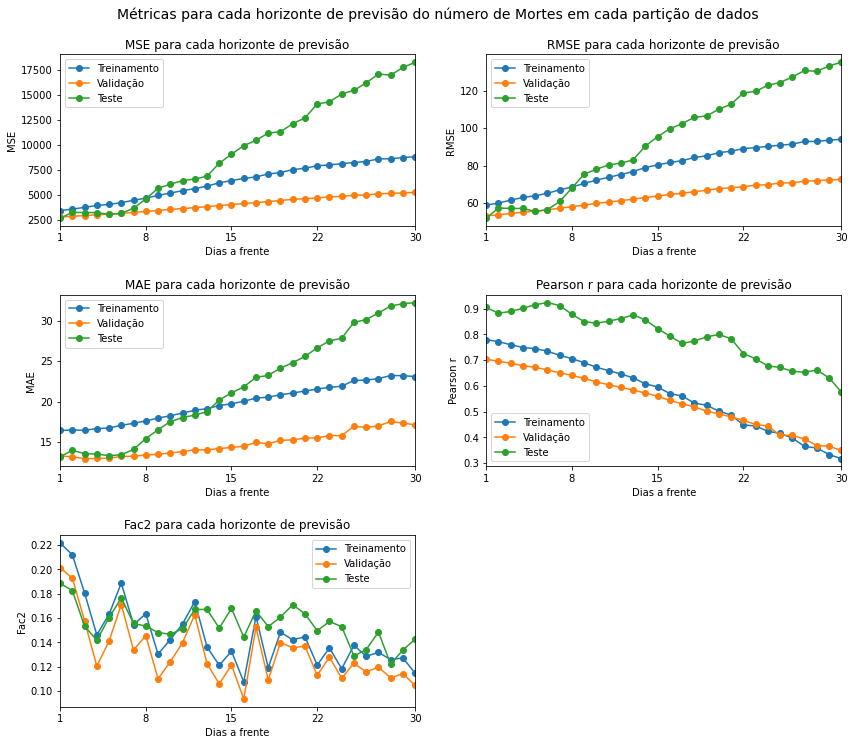

In [25]:
dict_metrics = {
    'Treinamento': train_metrics,
    'Validação': val_metrics,
    'Teste': test_metrics
}
plot_metrics(dict_metrics, title='Métricas para cada horizonte de previsão do número de Mortes em cada partição de dados')
# plt.savefig("./Imagens/Comparativo_metricas_TVT.png", dpi=600)

#### K-FOLD

In [26]:
dados_kf = dados_sinteticos.copy()

In [27]:
kf = KFold(n_splits = 5, shuffle = False)

MSEscores = []
RMSEscores = []
MAEscores = []
FACscores = []
Rscores = []

num_k = 0
for train, test in kf.split(dados_kf):
    
    dados_treino_kf = dados_kf.iloc[train]
    dados_teste_kf =  dados_kf.iloc[test]
    
    x_columns = ["ID","Deaths", "Confirmed", "C1","C2","C3","C4","C5","C6","C7","C8"]
    y_columns = ["Deaths"]
    col = x_columns + y_columns
    
    dados_treino_kf = dados_treino_kf[col]
    dados_teste_kf = dados_teste_kf[col]
    
    normalizador = MinMaxScaler(feature_range=(0, 1))

    norm_dados_treino = normalizador.fit_transform(dados_treino_kf)
    norm_dados_teste = normalizador.transform(dados_teste_kf)
    
    normalizador_t = MinMaxScaler(feature_range=(0, 1))
    previsores_normalizado = normalizador_t.fit_transform(dados_treino_kf.iloc[:,[-1]])
    
    treinamento_X_kf, treinamento_Y_kf = preditores_targets(norm_dados_treino, lookback, lookforward)
    teste_X_kf, teste_Y_kf = preditores_targets(norm_dados_teste, lookback, lookforward)
    
    ###########################################################################################################################
    #Arquitetura da RNA
    activation = 'relu'
    opt = optimizers.RMSprop(lr=1e-4)


    tf.random.set_seed(0)

    modelo = Sequential()
    modelo.add(Conv1D(filters=128, kernel_size=7, padding='same', activation= activation, input_shape = (treinamento_X_kf.shape[1],treinamento_X_kf.shape[2] )))
    modelo.add(MaxPooling1D(pool_size=2, padding='same'))

    modelo.add(LSTM(units = 40, return_sequences = True, activation=activation))
    modelo.add(LSTM(units = 35, return_sequences = True, activation=activation))
    modelo.add(LSTM(units = 30, activation = activation))
    modelo.add(Dense(units = lookforward, activation = activation))

    modelo.compile(optimizer=opt, loss='mse')


    #Execução
    history = modelo.fit(treinamento_X_kf, treinamento_Y_kf, shuffle=False ,batch_size = 1500, epochs = 150, verbose=0)
    ###########################################################################################################################

    predicao = modelo.predict(teste_X_kf) 
    predicao = normalizador_t.inverse_transform(predicao)
    observado = normalizador_t.inverse_transform(teste_Y_kf)
    
    predicao = pd.DataFrame(predicao)
    observado = pd.DataFrame(observado)
    
    warnings.filterwarnings('ignore')

    metricas_qualidade = get_metrics(observado, predicao)
    MSE = metricas_qualidade["MSE"].mean()
    RMSE = metricas_qualidade["RMSE"].mean()
    MAE = metricas_qualidade["MAE"].mean()
    R = metricas_qualidade["Pearson r"].mean()
    FAC2 = metricas_qualidade["Fac2"].mean()
    
    print("K: " + str(num_k))
    print("MSE: ", MSE)
    print("RMSE: ", RMSE)
    print("MAE: ", MAE)
    print("R: ", R)
    print("FAC2: ", FAC2)
    print("-----------------------------------")
    MSEscores.append(MSE)
    RMSEscores.append(RMSE)
    MAEscores.append(MAE)
    Rscores.append(R)
    FACscores.append(FAC2)
    num_k = num_k + 1
    
print("RESULTS K-FOLD: ")
print("MSE: " + str(np.mean(MSEscores)) + " +/- " +  str(np.std(MSEscores)))
print("RMSE: " + str(np.mean(RMSEscores)) + " +/- " +  str(np.std(RMSEscores)))
print("MAE: " + str(np.mean(MAEscores)) + " +/- " +  str(np.std(MAEscores)))
print("R: " + str(np.mean(Rscores)) + " +/- " +  str(np.std(Rscores)))
print("FAC2: " + str(np.mean(FACscores)) + " +/- " +  str(np.std(FACscores)))

A serie temporal com identificação 0.0 não foi considerada (poucos dados)
K: 0
MSE:  2469.0590425858218
RMSE:  49.583362824534504
MAE:  11.897460718400017
R:  0.3989572219099481
FAC2:  0.049283018697317126
-----------------------------------
A serie temporal com identificação 0.19385131145355147 não foi considerada (poucos dados)
K: 1
MSE:  4148.952361951221
RMSE:  64.13872581755008
MAE:  15.505678441875723
R:  0.4667878425931688
FAC2:  0.06397217839427181
-----------------------------------
A serie temporal com identificação 0.6086782605382959 não foi considerada (poucos dados)
K: 2
MSE:  7261.150199283284
RMSE:  83.78204997130449
MAE:  16.75152393573231
R:  0.5892460962699507
FAC2:  0.07130031005580549
-----------------------------------
A serie temporal com identificação 0.6086782605382959 não foi considerada (poucos dados)
K: 3
MSE:  6232.013337187054
RMSE:  78.47721866881635
MAE:  21.37993950032464
R:  0.5197666454667098
FAC2:  0.08859560019939243
---------------------------------

#### TREINAMENTO COM DATASET COMPLETO

In [28]:
dados_treino_producao = dados_sinteticos.copy()

In [29]:
x_columns = ["ID","Deaths", "Confirmed", "C1","C2","C3","C4","C5","C6","C7","C8"]
y_columns = ["Deaths"]
col = x_columns + y_columns

In [30]:
dados_treino_producao = dados_treino_producao[col]

print(dados_treino_producao.shape)

(12001274, 12)


In [31]:
normalizador = MinMaxScaler(feature_range=(0, 1))

norm_dados_treino = normalizador.fit_transform(dados_treino_producao)

normalizador_t = MinMaxScaler(feature_range=(0, 1))
previsores_normalizado = normalizador_t.fit_transform(dados_treino_producao.iloc[:,[-1]])

#### SALVANDO O NORMALIZADOR
dump(normalizador, open('Normalizador_Preditores_PRODUCAO.pkl', 'wb'))
dump(normalizador_t, open('Normalizador_Target_PRODUCAO.pkl', 'wb'))

In [32]:
treinamento_X_prod, treinamento_Y_prod = preditores_targets(norm_dados_treino, lookback, lookforward)

In [33]:
###########################################################################################################################
#Arquitetura da RNA
activation = 'relu'
opt = optimizers.RMSprop(lr=1e-4)


tf.random.set_seed(0)

modelo = Sequential()
modelo.add(Conv1D(filters=128, kernel_size=7, padding='same', activation= activation, input_shape = (treinamento_X_prod.shape[1],treinamento_X_prod.shape[2])))
modelo.add(MaxPooling1D(pool_size=2, padding='same'))

modelo.add(LSTM(units = 40, return_sequences = True, activation=activation))
modelo.add(LSTM(units = 35, return_sequences = True, activation=activation))
modelo.add(LSTM(units = 30, activation = activation))
modelo.add(Dense(units = lookforward, activation = activation))

modelo.compile(optimizer=opt, loss='mse')


#Execução
history = modelo.fit(treinamento_X_prod, treinamento_Y_prod, shuffle=False ,batch_size = 1500, epochs = 150, verbose=2)
###########################################################################################################################

Train on 10268774 samples
Epoch 1/150
10268774/10268774 - 53s - loss: 3.5990e-04
Epoch 2/150
10268774/10268774 - 51s - loss: 3.1826e-04
Epoch 3/150
10268774/10268774 - 51s - loss: 3.1395e-04
Epoch 4/150
10268774/10268774 - 50s - loss: 3.1011e-04
Epoch 5/150
10268774/10268774 - 50s - loss: 3.0661e-04
Epoch 6/150
10268774/10268774 - 50s - loss: 3.0363e-04
Epoch 7/150
10268774/10268774 - 49s - loss: 3.0145e-04
Epoch 8/150
10268774/10268774 - 50s - loss: 2.9973e-04
Epoch 9/150
10268774/10268774 - 50s - loss: 2.9798e-04
Epoch 10/150
10268774/10268774 - 50s - loss: 2.9673e-04
Epoch 11/150
10268774/10268774 - 50s - loss: 2.9567e-04
Epoch 12/150
10268774/10268774 - 49s - loss: 2.9469e-04
Epoch 13/150
10268774/10268774 - 49s - loss: 2.9365e-04
Epoch 14/150
10268774/10268774 - 49s - loss: 2.9308e-04
Epoch 15/150
10268774/10268774 - 49s - loss: 2.9234e-04
Epoch 16/150
10268774/10268774 - 49s - loss: 2.9200e-04
Epoch 17/150
10268774/10268774 - 49s - loss: 2.9142e-04
Epoch 18/150
10268774/10268774 

#### SALVANDO O MODELO (PRPDUÇÃO)

In [34]:
modelo.save('Modelo_CNN_LSTM_PRODUCAO.h5')

#### VERIFICAÇÃO DO LOSS

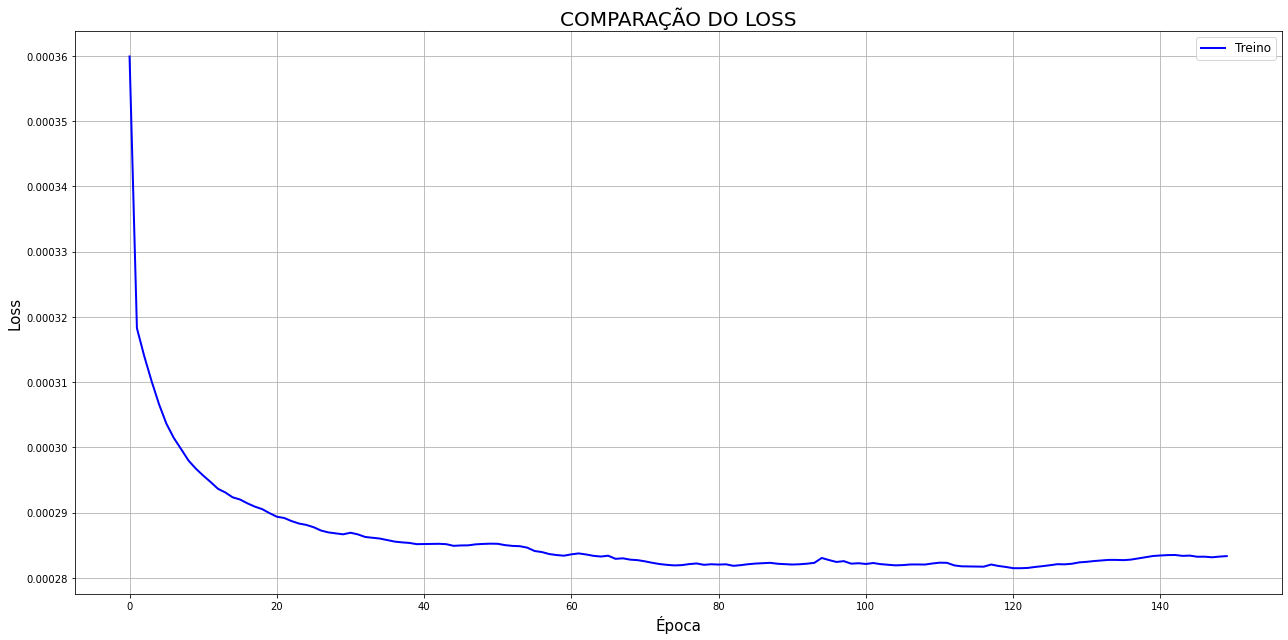

In [35]:
plt.figure(figsize=(18,9))

plt.plot(history.history['loss'], label = "Treino", linewidth =2, color ='blue')        

plt.title('COMPARAÇÃO DO LOSS', fontsize =20)
plt.xlabel('Época', fontsize =15)
plt.ylabel('Loss',fontsize =15)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("Imagens/CNN_LSTM_Grafico_de_loss_PRODUCAO.png", dpi=600)
plt.show()

In [36]:
time_elapsed = datetime.now() - start_time 
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Time elapsed (hh:mm:ss.ms) 13:13:22.824674
